In [1]:
%run setup.ipynb

In [2]:
# Function to support searching a scipy tree.

def get_descendant(node, desc_id):
    """Search the descendants of the given node.
    
    Parameters
    ----------
    node : scipy.cluster.hierarchy.ClusterNode
        The ancestor node to search from.
    desc_id : int
        The ID of the node to search for.
        
    Returns
    -------
    desc : scipy.cluster.hierarchy.ClusterNode
        If a node with the given ID is not found, returns None.
    
    """
    if node.id == desc_id:
        return node
    if node.is_leaf():
        return None
    if node.left.id == desc_id:
        return node.left
    if node.right.id == desc_id:
        return node.right
    # search left
    l = get_descendant(node.left, desc_id)
    if l is not None:
        return l
    # search right
    r = get_descendant(node.right, desc_id)
    return r


# monkey-patch as a method
scipy.cluster.hierarchy.ClusterNode.get_descendant = get_descendant

In [3]:
def fig_haplotypes_clustered(h,
                             distance_metric='hamming',
                             linkage_method='single',
                             truncate_distance=0,
                             orientation='top',
                             subplot_ratios=(4, 2),
                             subplot_pad=0,
                             despine_offset=5,
                             count_sort=True,
                             dend_linecolor='k',
                             cut_height=2,
                             highlight_clusters=True,
                             highlight_colors=None,
                             highlight_dend=True,
                             highlight_freq=True,
                             highlight_alpha=0.3,
                             label_clusters=True,
                             dpi=None,
                             fig=None,
                             ):
    """Construct a plot of hierarchical clustering of haplotypes.
    
    Parameters
    ----------
    TODO
    
    Returns
    -------
    TODO
    
    """
    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # compute distance matrix
    dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
    if distance_metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= h.n_variants
    
    # compute hierarchical clustering
    Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    # Z is a linkage matrix. From the scipy docs...
    # A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with 
    # indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster 
    # with an index less than n corresponds to one of the original observations. 
    # The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The 
    # fourth value Z[i, 3] represents the number of original observations in the 
    # newly formed cluster.
    
    # find level to truncate dendrogram
    lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
    
    # convenience variables
    horizontal = orientation in ['left', 'right']
    vertical = not horizontal
    inverted = orientation in ['bottom', 'right']
    
    # setup figure
    if fig is None:
        figsize = plt.rcParams['figure.figsize']
        if horizontal:
            figsize = figsize[::-1]
        fig = plt.figure(figsize=figsize, dpi=dpi)
        
    # setup gridspec and axes
    if inverted:
        subplot_ratios = subplot_ratios[::-1]
    if horizontal:
        gs = plt.GridSpec(nrows=1, ncols=2, width_ratios=subplot_ratios)
    else:
        gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=subplot_ratios)
    if inverted:
        ax_dend = fig.add_subplot(gs[1])
        ax_freq = fig.add_subplot(gs[0])
    else:
        ax_dend = fig.add_subplot(gs[0])
        ax_freq = fig.add_subplot(gs[1])
    if horizontal:
        sns.despine(ax=ax_dend, offset=despine_offset, 
                    left=True, top=True, right=True, bottom=False)
        sns.despine(ax=ax_freq, offset=despine_offset, 
                    left=True, top=True, right=True, bottom=False)
    else:
        sns.despine(ax=ax_dend, offset=despine_offset, 
                    left=False, top=True, right=True, bottom=True)
        sns.despine(ax=ax_freq, offset=despine_offset, 
                    left=False, top=True, right=True, bottom=True)

    # make a dendrogram
    kwargs_dend = dict(
        truncate_mode='lastp', 
        p=lastp,
        show_leaf_counts=False, 
        count_sort=count_sort, 
        no_labels=True, 
        color_threshold=0, 
        above_threshold_color=dend_linecolor, 
        orientation=orientation
    )    
    dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs_dend)
    leaves = dend['leaves']
    ax_dend_label = 'Distance'
    if horizontal:
        ax_dend.set_xlabel(ax_dend_label)
        ax_dend.set_yticks([])
    else:
        ax_dend.set_ylabel(ax_dend_label)
        ax_dend.set_xticks([])
        
    # construct a tree and compute observation counts for the dendrogram leaves
    tree = scipy.cluster.hierarchy.to_tree(Z)
    s = np.arange(len(leaves))
    t = np.array([
        1 if l < h.n_haplotypes
        else tree.get_descendant(l).get_count()
        for l in leaves
    ])

    # plot frequencies bar
    ax_freq_label = 'Frequency'
    if horizontal:
        ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
        ax_freq.set_ylim(0, len(leaves))
        ax_freq.set_yticks([])
        ax_freq.set_xlabel(ax_freq_label)
        ax_freq.grid(axis='x', lw=.5)
        if orientation == 'right':
            ax_freq.invert_xaxis()
        # remove 0
        ax_freq.set_xticks(ax_freq.get_xticks()[1:])
    else:
        ax_freq.bar(s, t, width=1, lw=0, color='k', align='edge')
        ax_freq.set_xlim(0, len(leaves))
        ax_freq.set_xticks([])
        ax_freq.set_ylabel(ax_freq_label)
        ax_freq.grid(axis='y', lw=.5)
        if orientation == 'top':
            ax_freq.invert_yaxis()
        # remove 0
        ax_freq.set_yticks(ax_freq.get_yticks()[1:])

    # cut the tree
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # now the fiddly bit - we need to figure out where the clusters have
    # ended up in the dendrogram we plotted earlier...
    
    # N.B., the dendrogram was truncated, so each leaf in the dendrogram
    # may correspond to more than one original observation (i.e., haplotype).
    # Let's build a list storing the observations for each leaf:
    leaf_obs = [tree.get_descendant(ix).pre_order() for ix in leaves]
    
    # Now let's figure out for each leaf in the dendrogram, which of the clusters
    # obtained by cutting the tree earlier does it fall into?
    leaf_clusters = np.array([cut[l[0]] for l in leaf_obs])
    
    # Now let's build a data structure that reorders the clusters so they
    # occur in the same order as in the dendrogram, and also record the indices
    # of the start and stop leaf for each cluster:
    cluster_spans = list()
    c_prv = leaf_clusters[0]
    i_start = 0
    for i, c in enumerate(leaf_clusters[1:], 1):
        if c != c_prv:
            cluster_spans.append((i_start, i, clusters[c_prv]))
            i_start = i
        c_prv = c
    # don't forget the last one
    cluster_spans.append((i_start, i+1, clusters[c]))
    
    # OK, now figure out which clusters we want to highlight...
    if isinstance(highlight_clusters, (list, tuple)):
        # user has manually specified which clusters to highlight
        pass
    else:
        # assume highlight_clusters is the minimum cluster size to highlight
        min_cluster_size = int(highlight_clusters)
        highlight_clusters = [i for i, cs in enumerate(cluster_spans) 
                              if len(cs[2]) >= min_cluster_size]
        
    # setup colors for highlighting clusters
    if highlight_colors is None:
        highlight_colors = sns.color_palette('hls', n_colors=len(highlight_clusters))
        
    # do the highlighting
    for color, cix in zip(highlight_colors, highlight_clusters):
        start, stop, _ = cluster_spans[cix]
        if horizontal:
            freq_spanf = ax_freq.axhspan
            dend_patch_xy = (0, start * 10)
            dend_patch_width = cut_height
            dend_patch_height = (stop - start) * 10
        else:
            freq_spanf = ax_freq.axvspan
            dend_patch_xy = (start * 10, 0)
            dend_patch_width = (stop - start) * 10
            dend_patch_height = cut_height
        if highlight_freq:
            freq_spanf(start, stop, color=color, alpha=highlight_alpha, zorder=-20)
        if highlight_dend:
            ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                            width=dend_patch_width, 
                                            height=dend_patch_height, 
                                            color=color, alpha=highlight_alpha, 
                                            zorder=-20))

    # for debugging, label the clusters
    if label_clusters:
        for i, (start, stop, clst) in enumerate(cluster_spans):
            if horizontal:
                x = max(ax_freq.get_xlim())
                y = (start + stop) / 2
                ha = orientation
                va = 'center'
            else:
                x = (start + stop) / 2
                y = max(ax_freq.get_ylim())
                ha = 'center'
                va = orientation
            # treat label_clusters as minimum cluster size to label
            if len(clst) >= int(label_clusters):
                ax_freq.text(x, y, str(i), 
                             va=va, ha=ha, fontsize=6)
    
    # tidy up plot
    if horizontal:
        gs.tight_layout(fig, w_pad=subplot_pad)
    else:
        gs.tight_layout(fig, h_pad=subplot_pad)
    
    # return some useful stuff
    return fig, ax_dend, ax_freq, cluster_spans, leaf_obs


In [4]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)


In [5]:
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
tbl_haplotypes

0|index,1|label,2|ox_code,3|population,4|label_aug,5|country,6|region,7|sex,8|m_s,9|kt_2la,10|kt_2rb
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [6]:
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995S[:5]

array(['palegreen', 'palegreen', 'palegreen', 'palegreen', 'palegreen'], 
      dtype='<U11')

## Begin function definition

In [7]:
# arg
h = h_vgsc_995S

In [8]:
# arg
hap_colors = hap_colors_995S

In [9]:
h_distinct_sets = h.distinct()
h_distinct_indices = [sorted(s)[0] for s in h_distinct_sets]
h_distinct_indices[:5]

[2, 0, 295, 273, 14]

In [10]:
h_distinct = h.take(h_distinct_indices, axis=1)
h_distinct

<HaplotypeArray shape=(1718, 62) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 1 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [11]:
color_counters = [
    collections.Counter([hap_colors[i] for i in s])
    for s in h_distinct_sets
]
color_counters

[Counter({'grey47': 50, 'palegreen': 80}),
 Counter({'palegreen': 85}),
 Counter({'dodgerblue3': 8, 'olivedrab': 47}),
 Counter({'dodgerblue3': 26}),
 Counter({'palegreen': 13}),
 Counter({'dodgerblue3': 11}),
 Counter({'grey47': 10}),
 Counter({'olivedrab': 9}),
 Counter({'dodgerblue3': 8}),
 Counter({'dodgerblue3': 6}),
 Counter({'palegreen': 6}),
 Counter({'olivedrab': 6}),
 Counter({'dodgerblue3': 4}),
 Counter({'dodgerblue3': 3}),
 Counter({'dodgerblue3': 3}),
 Counter({'dodgerblue3': 3}),
 Counter({'dodgerblue3': 2}),
 Counter({'olivedrab': 2}),
 Counter({'dodgerblue3': 2}),
 Counter({'palegreen': 2}),
 Counter({'palegreen': 2}),
 Counter({'palegreen': 2}),
 Counter({'dodgerblue3': 1}),
 Counter({'olivedrab': 1}),
 Counter({'grey47': 1}),
 Counter({'palegreen': 1}),
 Counter({'palegreen': 1}),
 Counter({'grey47': 1}),
 Counter({'palegreen': 1}),
 Counter({'olivedrab': 1}),
 Counter({'grey47': 1}),
 Counter({'olivedrab': 1}),
 Counter({'dodgerblue3': 1}),
 Counter({'dodgerblue3': 

In [12]:
hap_counts = [len(s) for s in h_distinct_sets]
hap_counts[:5]

[130, 85, 55, 26, 13]

In [13]:
# arg
distance_metric = 'hamming'

In [14]:
dist = allel.pairwise_distance(h_distinct, metric=distance_metric)
dist *= h.n_variants
dist = scipy.spatial.distance.squareform(dist).astype(int)
dist

array([[ 0, 76, 39, ..., 72,  2,  2],
       [76,  0, 71, ...,  4, 76, 78],
       [39, 71,  0, ..., 67, 39, 41],
       ..., 
       [72,  4, 67, ...,  0, 72, 74],
       [ 2, 76, 39, ..., 72,  0,  2],
       [ 2, 78, 41, ..., 74,  2,  0]])

In [15]:
mst = scipy.sparse.csgraph.minimum_spanning_tree(dist).toarray().astype(int)
mst

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 39,  0],
       ..., 
       [ 0,  4,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [60]:
# args
comment = None
engine = 'neato'
format = 'png'
mode = 'major'
overlap = False
splines = False
node_size_factor = 0.02
edge_length = .5
anon_width = 0.07
anon_fillcolor = 'white'
intermediate_nodes = True
max_dist = 5

In [61]:
# setup graph
graph = graphviz.Graph(comment=comment, engine=engine, format=format)
graph.attr('graph', overlap=str(overlap).lower(), splines=str(splines).lower(), mode=mode)

In [62]:
# add the main nodes
for i, (n, cc) in enumerate(zip(hap_counts, color_counters)):
    
    # calculate width from number of items
    width = np.sqrt(n * node_size_factor)
    
    # determine style and fill color
    if len(cc) > 1:
        style = 'wedged'
        fillcolor = ':'.join(['%s;%s' % (k, v/n) for k, v in cc.items()])
    else:
        style = 'filled'
        fillcolor = list(cc.keys())[0]

    # add graph node
    print('node', i, width, fillcolor)
    graph.node(str(i), shape='circle', width=str(width), style=style, fillcolor=fillcolor, fixedsize='true', label='')
        

node 0 1.61245154966 grey47;0.38461538461538464:palegreen;0.6153846153846154
node 1 1.30384048104 palegreen
node 2 1.04880884817 dodgerblue3;0.14545454545454545:olivedrab;0.8545454545454545
node 3 0.721110255093 dodgerblue3
node 4 0.509901951359 palegreen
node 5 0.469041575982 dodgerblue3
node 6 0.4472135955 grey47
node 7 0.424264068712 olivedrab
node 8 0.4 dodgerblue3
node 9 0.346410161514 dodgerblue3
node 10 0.346410161514 palegreen
node 11 0.346410161514 olivedrab
node 12 0.282842712475 dodgerblue3
node 13 0.244948974278 dodgerblue3
node 14 0.244948974278 dodgerblue3
node 15 0.244948974278 dodgerblue3
node 16 0.2 dodgerblue3
node 17 0.2 olivedrab
node 18 0.2 dodgerblue3
node 19 0.2 palegreen
node 20 0.2 palegreen
node 21 0.2 palegreen
node 22 0.141421356237 dodgerblue3
node 23 0.141421356237 olivedrab
node 24 0.141421356237 grey47
node 25 0.141421356237 palegreen
node 26 0.141421356237 palegreen
node 27 0.141421356237 grey47
node 28 0.141421356237 palegreen
node 29 0.141421356237 ol

In [63]:
# add edges
for i in range(mst.shape[0]):

    for j in range(mst.shape[1]):
        
        # lookup distance between nodes i and j
        sep = mst[i, j]
        
        if sep > 0 and (max_dist is None or sep <= max_dist):
            print('connecting', i, j, sep)
            
            # lookup number of haplotypes
            n_i = hap_counts[i]
            n_j = hap_counts[j]
            
            # calculate node sizes (needed to adjust edge length)
            width_i = np.sqrt(n_i * node_size_factor)
            width_j = np.sqrt(n_j * node_size_factor)
            
            if sep > 1 and intermediate_nodes:
                
                # tricky case, need to add some anonymous nodes to represent intermediate steps

                # add first intermediate node
                nid = 'anon_{}_{}_{}'.format(i, j, 0)
                graph.node(nid, shape='circle', style='filled', fillcolor=anon_fillcolor, fixedsize='true', label='', width=str(anon_width))

                # add edge from node i to first intermediate
                el = edge_length + width_i / 2 + anon_width / 2
                graph.edge(str(i), 'anon_{}_{}_{}'.format(i, j, 0), **{'len': str(el)})

                # add further intermediate nodes as necessary
                for k in range(1, sep-1):
                    nid = 'anon_{}_{}_{}'.format(i, j, k)
                    graph.node(nid, shape='circle', style='filled', fillcolor=anon_fillcolor, fixedsize='true', label='', width=str(anon_width))
                    el = edge_length + anon_width
                    graph.edge('anon_{}_{}_{}'.format(i, j, k-1), 'anon_{}_{}_{}'.format(i, j, k), **{'len': str(el)})

                # add edge from final intermediate node to node j
                el = edge_length + anon_width / 2 + width_j / 2 
                graph.edge('anon_{}_{}_{}'.format(i, j, sep-2), str(j), **{'len': str(el)})
                
            else:
                
                # simple case, direct edge from node i to j

                # N.B., adjust edge length so we measure distance from edge of circle rather than center
                el = (edge_length * sep) + width_i / 2 + width_j / 2
                graph.edge(str(i), str(j), **{'len': str(el)})

            

connecting 0 26 1
connecting 0 27 1
connecting 1 10 1
connecting 1 19 1
connecting 1 20 1
connecting 1 28 1
connecting 1 39 1
connecting 1 46 1
connecting 1 47 1
connecting 1 48 1
connecting 2 7 1
connecting 2 23 1
connecting 3 14 1
connecting 4 0 1
connecting 5 12 1
connecting 5 13 1
connecting 5 18 1
connecting 5 22 2
connecting 5 33 1
connecting 6 0 1
connecting 6 60 1
connecting 6 61 1
connecting 8 13 1
connecting 9 14 1
connecting 17 11 1
connecting 18 16 1
connecting 21 20 1
connecting 24 0 1
connecting 25 1 2
connecting 30 0 2
connecting 31 2 4
connecting 32 8 2
connecting 34 1 1
connecting 35 11 1
connecting 35 54 1
connecting 36 4 2
connecting 37 1 1
connecting 38 9 2
connecting 38 44 2
connecting 40 0 1
connecting 41 0 1
connecting 42 0 1
connecting 43 4 1
connecting 45 1 1
connecting 49 2 1
connecting 50 2 1
connecting 51 5 1
connecting 51 58 1
connecting 52 1 1
connecting 53 5 3
connecting 54 2 1
connecting 55 2 1
connecting 57 0 1
connecting 59 1 4


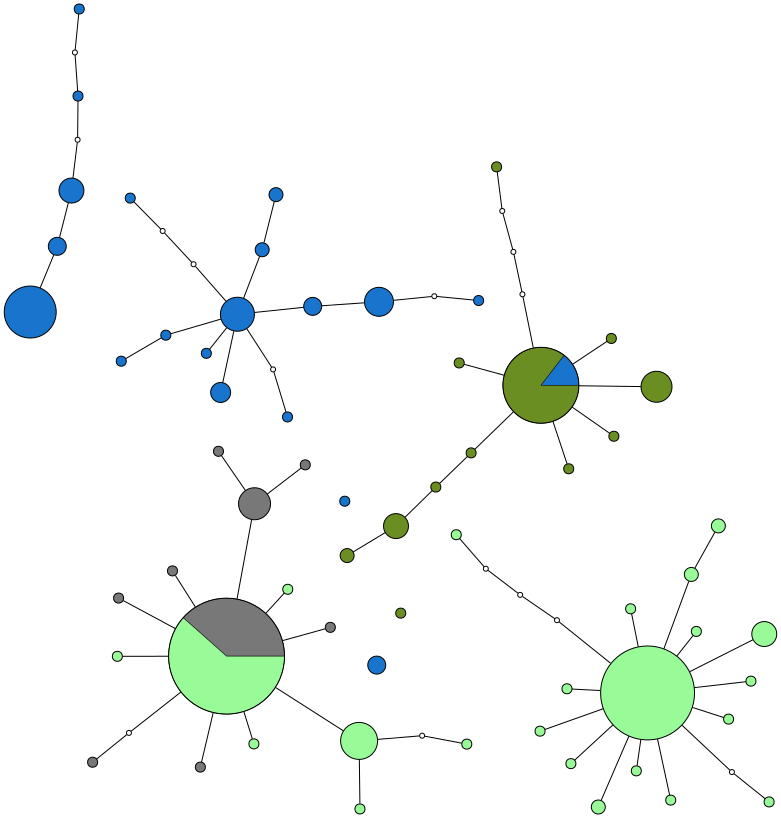

In [64]:
graph